# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
!pip install tqdm

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from pydrive.drive import GoogleDrive

drive = GoogleDrive(gauth) # Create GoogleDrive instance with authenticated GoogleAuth instance

In [0]:
helper_file = drive.CreateFile({'id': '15dp94Og6NmQ_NpklySDAQ4RWSCcvBSgm'})
helper_file.GetContentFile('helper.py')

problem_unittests_file = drive.CreateFile({'id': '1Zii7C8xFeLKm5rDL9drbkEbAv9vDVCjY'})
problem_unittests_file.GetContentFile('problem_unittests.py')

In [6]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0k/60.0k [00:12<00:00, 4.65kFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

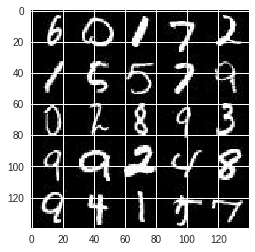

In [7]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import numpy as np
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
#pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')
pyplot.imshow(np.array(helper.images_square_grid(mnist_images, 'L')), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

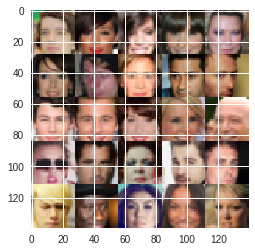

In [8]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.12.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [10]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return (inputs_real, inputs_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [11]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):

        alpha = 0.2
        momentum = 0.99
        
        # Input layer is 28x28x[out_channel_dim]
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        x1 = tf.nn.leaky_relu(x1, alpha)
        # 14x14x256
        
        x2 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, momentum=momentum, training=True)
        x2 = tf.nn.leaky_relu(x2, alpha)
        # 7x7x512
        
        x3 = tf.layers.conv2d(x2, 512, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, momentum=momentum, training=True)
        x3 = tf.nn.leaky_relu(x3, alpha)
      
        # Flatten
        flat = tf.reshape(x3, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

    return (output, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()  File "/usr/local/lib/python3.6/dist-packages/tornado/ioloop.py", line 832, in start
    self._run_callback(self._callbacks.popleft())  File "/usr/local/lib/p

## Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [12]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        drop_rate = 0.2
        momentum = 0.99
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*1024)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 1024))
        x1 = tf.layers.batch_normalization(x1, momentum=momentum, training=is_train)
        x1 = tf.nn.leaky_relu(x1, alpha)
        x1 = tf.layers.dropout(x1, rate=drop_rate)
        # 7x7x512 

        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, momentum=momentum, training=is_train)
        x2 = tf.nn.leaky_relu(x2, alpha)
        # 14x14x512 
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, momentum=momentum, training=is_train)
        x3 = tf.nn.leaky_relu(x3, alpha)
        x3 = tf.layers.dropout(x3, rate=drop_rate)
        # 28x28x256
        
        
        x4 = tf.layers.conv2d_transpose(x3, 256, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, momentum=momentum, training=is_train)
        x4 = tf.nn.leaky_relu(x4, alpha)
        
        x5 = tf.layers.conv2d_transpose(x4, 256, 5, strides=1, padding='same')
        x5 = tf.layers.batch_normalization(x5, momentum=momentum, training=is_train)
        x5 = tf.nn.leaky_relu(x5, alpha)
        x5 = tf.layers.dropout(x5, rate=drop_rate)
        
        x6 = tf.layers.conv2d_transpose(x5, 256, 5, strides=1, padding='same')
        x6 = tf.layers.batch_normalization(x6, momentum=momentum, training=is_train)
        x6 = tf.nn.leaky_relu(x6, alpha)
        

        # Output layer
        logits = tf.layers.conv2d_transpose(x6, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x[out_channel_dim] 

        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [13]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    with tf.variable_scope(tf.get_variable_scope()):
        g_model = generator(input_z, out_channel_dim, is_train=True)
        d_model_real, d_logits_real = discriminator(input_real, reuse=False)
        d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    smooth = 0.1
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake) ))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [14]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    d_vars = tf.trainable_variables(scope='discriminator')
    g_vars = tf.trainable_variables(scope='generator')
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_opt, g_train_opt)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    #pyplot.imshow(images_grid, cmap=cmap)
    #pyplot.imshow(helper.images_square_grid(np.array(images_grid), cmap=cmap))
    pyplot.imshow(np.array(images_grid), cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [0]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    losses = []
    steps = 0
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    out_channel_dim = data_shape[3]
    if data_image_mode == 'RGB':
        image_channels = 3
    else:
        image_channels = 1
    
    inputs_real, inputs_z, learning_rate_ = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(inputs_real, inputs_z, out_channel_dim)
    
    d_train_opt, g_train_opt= model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
              
                
                batch_images = batch_images * 2
                
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1.0, 1.0, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z})

                
                if steps % 20 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_real: batch_images, inputs_z: batch_z})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    

                if steps % 100 == 0:
                    show_generator_output(sess, 25, inputs_z, out_channel_dim, data_image_mode)

    
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 5.5395... Generator Loss: 3.9857
Epoch 1/2... Discriminator Loss: 3.4017... Generator Loss: 0.0876
Epoch 1/2... Discriminator Loss: 3.4518... Generator Loss: 0.0630
Epoch 1/2... Discriminator Loss: 2.6298... Generator Loss: 0.1618
Epoch 1/2... Discriminator Loss: 2.2584... Generator Loss: 0.2459


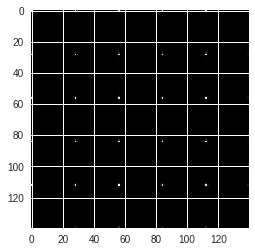

Epoch 1/2... Discriminator Loss: 2.9772... Generator Loss: 0.1042
Epoch 1/2... Discriminator Loss: 1.9944... Generator Loss: 0.4105
Epoch 1/2... Discriminator Loss: 2.2861... Generator Loss: 0.9278
Epoch 1/2... Discriminator Loss: 2.1852... Generator Loss: 0.3983
Epoch 1/2... Discriminator Loss: 2.1005... Generator Loss: 0.7071


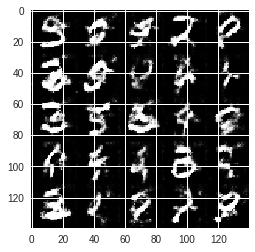

Epoch 1/2... Discriminator Loss: 1.9292... Generator Loss: 0.3649
Epoch 1/2... Discriminator Loss: 2.3269... Generator Loss: 0.1763
Epoch 1/2... Discriminator Loss: 2.0757... Generator Loss: 0.2342
Epoch 1/2... Discriminator Loss: 2.1127... Generator Loss: 0.2300
Epoch 1/2... Discriminator Loss: 2.1375... Generator Loss: 0.2102


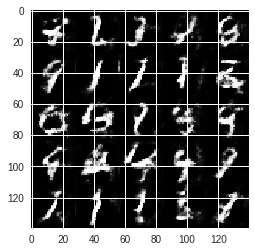

Epoch 1/2... Discriminator Loss: 1.6807... Generator Loss: 0.4778
Epoch 1/2... Discriminator Loss: 1.9513... Generator Loss: 0.2739
Epoch 1/2... Discriminator Loss: 2.1080... Generator Loss: 0.2694
Epoch 1/2... Discriminator Loss: 1.9937... Generator Loss: 0.2548
Epoch 1/2... Discriminator Loss: 2.1197... Generator Loss: 0.2500


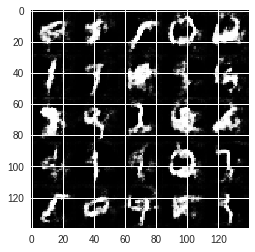

Epoch 1/2... Discriminator Loss: 1.7514... Generator Loss: 0.4441
Epoch 1/2... Discriminator Loss: 1.9611... Generator Loss: 0.2516
Epoch 1/2... Discriminator Loss: 2.1443... Generator Loss: 0.2025
Epoch 1/2... Discriminator Loss: 1.7477... Generator Loss: 0.4929
Epoch 1/2... Discriminator Loss: 1.5828... Generator Loss: 0.6735


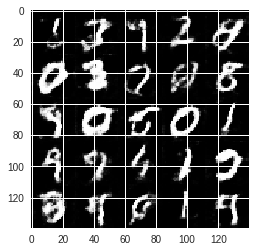

Epoch 1/2... Discriminator Loss: 1.9150... Generator Loss: 0.3089
Epoch 1/2... Discriminator Loss: 1.8755... Generator Loss: 0.3416
Epoch 1/2... Discriminator Loss: 1.8042... Generator Loss: 0.3595
Epoch 1/2... Discriminator Loss: 2.0121... Generator Loss: 0.2626
Epoch 1/2... Discriminator Loss: 1.8486... Generator Loss: 0.3578


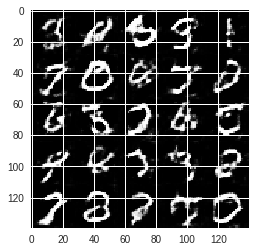

Epoch 1/2... Discriminator Loss: 1.7280... Generator Loss: 0.7290
Epoch 1/2... Discriminator Loss: 2.0044... Generator Loss: 0.7329
Epoch 1/2... Discriminator Loss: 1.6047... Generator Loss: 0.5614
Epoch 1/2... Discriminator Loss: 1.9532... Generator Loss: 0.2632
Epoch 1/2... Discriminator Loss: 1.6174... Generator Loss: 0.5352


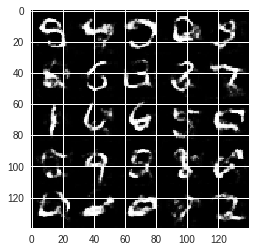

Epoch 1/2... Discriminator Loss: 1.8506... Generator Loss: 1.3599
Epoch 1/2... Discriminator Loss: 1.8043... Generator Loss: 0.5559
Epoch 1/2... Discriminator Loss: 1.6124... Generator Loss: 0.5489
Epoch 1/2... Discriminator Loss: 1.7104... Generator Loss: 0.4467
Epoch 1/2... Discriminator Loss: 1.6959... Generator Loss: 0.6572


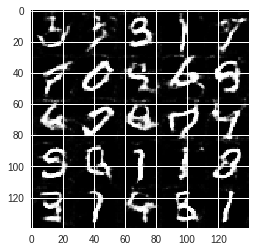

Epoch 1/2... Discriminator Loss: 1.6109... Generator Loss: 0.7972
Epoch 1/2... Discriminator Loss: 1.6673... Generator Loss: 0.5718
Epoch 1/2... Discriminator Loss: 1.9354... Generator Loss: 0.2850
Epoch 1/2... Discriminator Loss: 1.8670... Generator Loss: 0.3438
Epoch 1/2... Discriminator Loss: 1.6725... Generator Loss: 0.3850


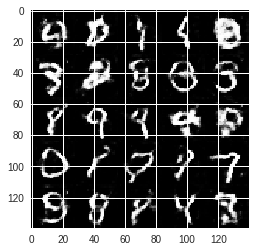

Epoch 1/2... Discriminator Loss: 1.7374... Generator Loss: 0.3593
Epoch 1/2... Discriminator Loss: 1.8178... Generator Loss: 0.3270
Epoch 1/2... Discriminator Loss: 1.8256... Generator Loss: 0.3302
Epoch 1/2... Discriminator Loss: 1.6392... Generator Loss: 0.9437
Epoch 1/2... Discriminator Loss: 1.5948... Generator Loss: 0.9473


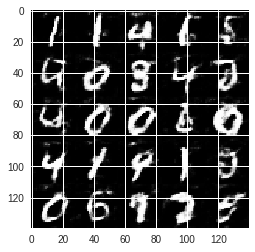

Epoch 1/2... Discriminator Loss: 1.6456... Generator Loss: 0.8479
Epoch 1/2... Discriminator Loss: 1.6140... Generator Loss: 0.5718
Epoch 1/2... Discriminator Loss: 1.6783... Generator Loss: 0.4321
Epoch 1/2... Discriminator Loss: 1.7469... Generator Loss: 0.3693
Epoch 1/2... Discriminator Loss: 1.6011... Generator Loss: 0.4257


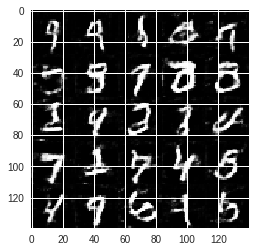

Epoch 1/2... Discriminator Loss: 1.7213... Generator Loss: 0.3881
Epoch 1/2... Discriminator Loss: 1.8227... Generator Loss: 0.9788
Epoch 1/2... Discriminator Loss: 1.6349... Generator Loss: 0.8399
Epoch 1/2... Discriminator Loss: 1.5840... Generator Loss: 0.8761
Epoch 1/2... Discriminator Loss: 1.6646... Generator Loss: 0.4346


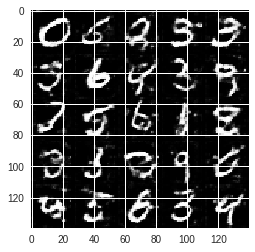

Epoch 1/2... Discriminator Loss: 1.6652... Generator Loss: 0.8240
Epoch 1/2... Discriminator Loss: 1.5948... Generator Loss: 0.4964
Epoch 1/2... Discriminator Loss: 1.6186... Generator Loss: 0.8962
Epoch 1/2... Discriminator Loss: 1.6851... Generator Loss: 1.1589
Epoch 1/2... Discriminator Loss: 1.5796... Generator Loss: 0.8867


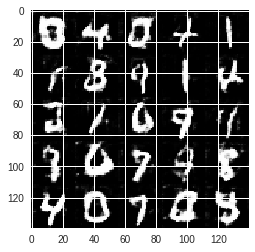

Epoch 1/2... Discriminator Loss: 1.5634... Generator Loss: 0.6495
Epoch 1/2... Discriminator Loss: 1.6603... Generator Loss: 1.0075
Epoch 1/2... Discriminator Loss: 1.6281... Generator Loss: 1.0004
Epoch 1/2... Discriminator Loss: 1.5818... Generator Loss: 0.5807
Epoch 1/2... Discriminator Loss: 1.6471... Generator Loss: 1.0047


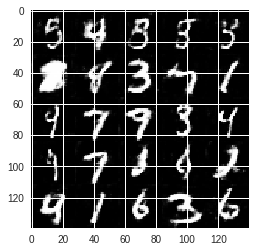

Epoch 1/2... Discriminator Loss: 1.7673... Generator Loss: 1.3588
Epoch 1/2... Discriminator Loss: 1.5993... Generator Loss: 1.0831
Epoch 1/2... Discriminator Loss: 1.5799... Generator Loss: 0.9721
Epoch 1/2... Discriminator Loss: 1.7369... Generator Loss: 1.2723
Epoch 1/2... Discriminator Loss: 1.5618... Generator Loss: 0.6446


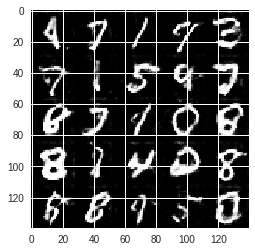

Epoch 1/2... Discriminator Loss: 1.5483... Generator Loss: 0.8539
Epoch 1/2... Discriminator Loss: 1.5329... Generator Loss: 1.0948
Epoch 1/2... Discriminator Loss: 1.5590... Generator Loss: 0.8892
Epoch 1/2... Discriminator Loss: 1.5923... Generator Loss: 0.8944
Epoch 1/2... Discriminator Loss: 1.5775... Generator Loss: 0.8570


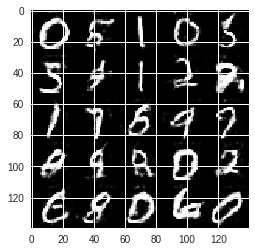

Epoch 1/2... Discriminator Loss: 1.5140... Generator Loss: 1.0301
Epoch 1/2... Discriminator Loss: 1.5781... Generator Loss: 0.7275
Epoch 1/2... Discriminator Loss: 1.7891... Generator Loss: 0.3205
Epoch 1/2... Discriminator Loss: 1.6185... Generator Loss: 0.4120
Epoch 1/2... Discriminator Loss: 1.6275... Generator Loss: 0.4356


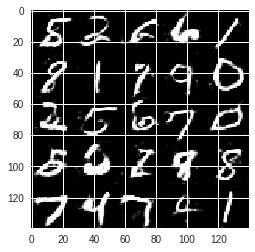

Epoch 1/2... Discriminator Loss: 1.4560... Generator Loss: 0.6430
Epoch 1/2... Discriminator Loss: 1.5463... Generator Loss: 0.5013
Epoch 1/2... Discriminator Loss: 1.7855... Generator Loss: 0.3307
Epoch 1/2... Discriminator Loss: 1.6754... Generator Loss: 0.3763
Epoch 1/2... Discriminator Loss: 1.5385... Generator Loss: 0.5305


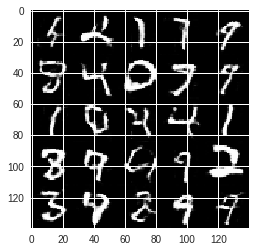

Epoch 1/2... Discriminator Loss: 1.4511... Generator Loss: 0.9372
Epoch 1/2... Discriminator Loss: 1.6209... Generator Loss: 1.0962
Epoch 1/2... Discriminator Loss: 1.5584... Generator Loss: 1.0607
Epoch 2/2... Discriminator Loss: 1.5674... Generator Loss: 0.9288
Epoch 2/2... Discriminator Loss: 1.5207... Generator Loss: 0.8896


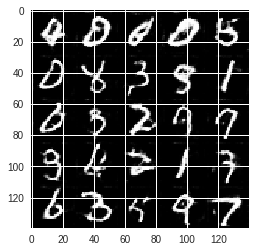

Epoch 2/2... Discriminator Loss: 1.4684... Generator Loss: 0.6696
Epoch 2/2... Discriminator Loss: 1.7368... Generator Loss: 0.3666
Epoch 2/2... Discriminator Loss: 1.5761... Generator Loss: 0.4659
Epoch 2/2... Discriminator Loss: 1.5684... Generator Loss: 0.4497
Epoch 2/2... Discriminator Loss: 1.6254... Generator Loss: 0.4127


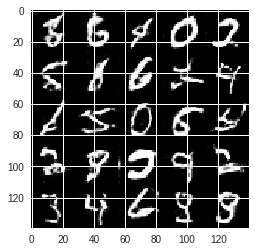

Epoch 2/2... Discriminator Loss: 1.7305... Generator Loss: 0.3515
Epoch 2/2... Discriminator Loss: 1.5498... Generator Loss: 0.4483
Epoch 2/2... Discriminator Loss: 1.7014... Generator Loss: 0.3587
Epoch 2/2... Discriminator Loss: 1.5651... Generator Loss: 0.4779
Epoch 2/2... Discriminator Loss: 1.6253... Generator Loss: 0.3860


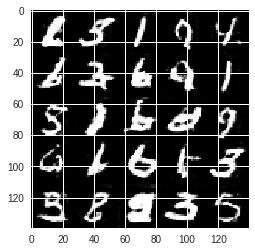

Epoch 2/2... Discriminator Loss: 1.5484... Generator Loss: 0.5311
Epoch 2/2... Discriminator Loss: 1.4921... Generator Loss: 0.6437
Epoch 2/2... Discriminator Loss: 1.4778... Generator Loss: 0.7041
Epoch 2/2... Discriminator Loss: 1.6852... Generator Loss: 0.3701
Epoch 2/2... Discriminator Loss: 1.5677... Generator Loss: 0.4540


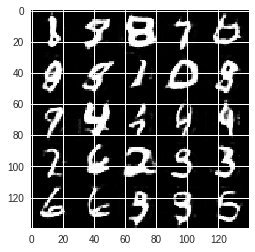

Epoch 2/2... Discriminator Loss: 1.6105... Generator Loss: 0.5163
Epoch 2/2... Discriminator Loss: 1.4763... Generator Loss: 0.9390
Epoch 2/2... Discriminator Loss: 1.5740... Generator Loss: 1.0886
Epoch 2/2... Discriminator Loss: 1.5924... Generator Loss: 0.9626
Epoch 2/2... Discriminator Loss: 1.5339... Generator Loss: 0.9652


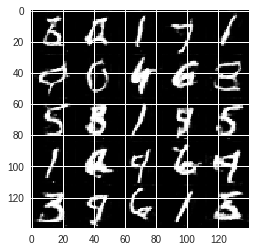

Epoch 2/2... Discriminator Loss: 1.5063... Generator Loss: 0.8352
Epoch 2/2... Discriminator Loss: 1.5539... Generator Loss: 1.0599
Epoch 2/2... Discriminator Loss: 1.6236... Generator Loss: 0.7340
Epoch 2/2... Discriminator Loss: 1.5580... Generator Loss: 0.9462
Epoch 2/2... Discriminator Loss: 1.5234... Generator Loss: 0.5333


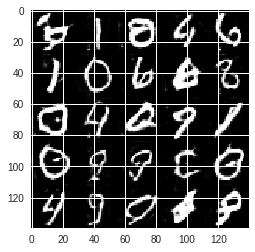

Epoch 2/2... Discriminator Loss: 1.5785... Generator Loss: 0.4645
Epoch 2/2... Discriminator Loss: 1.5282... Generator Loss: 0.5400
Epoch 2/2... Discriminator Loss: 1.4487... Generator Loss: 0.6556
Epoch 2/2... Discriminator Loss: 1.4704... Generator Loss: 0.6735
Epoch 2/2... Discriminator Loss: 1.7463... Generator Loss: 0.3470


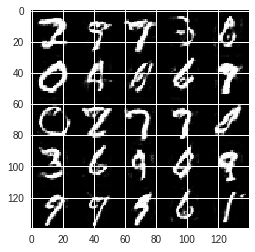

Epoch 2/2... Discriminator Loss: 1.7547... Generator Loss: 0.3551
Epoch 2/2... Discriminator Loss: 1.5459... Generator Loss: 0.9854
Epoch 2/2... Discriminator Loss: 1.5629... Generator Loss: 0.9964
Epoch 2/2... Discriminator Loss: 1.5616... Generator Loss: 0.5184
Epoch 2/2... Discriminator Loss: 1.6076... Generator Loss: 0.4168


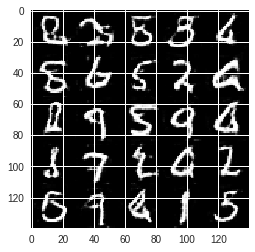

Epoch 2/2... Discriminator Loss: 1.6020... Generator Loss: 0.4192
Epoch 2/2... Discriminator Loss: 1.5954... Generator Loss: 0.4551
Epoch 2/2... Discriminator Loss: 1.6466... Generator Loss: 0.3840
Epoch 2/2... Discriminator Loss: 1.5123... Generator Loss: 0.5655
Epoch 2/2... Discriminator Loss: 1.5312... Generator Loss: 0.9631


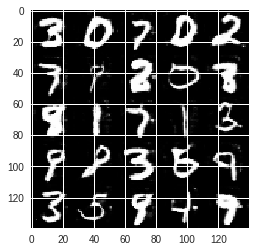

Epoch 2/2... Discriminator Loss: 1.6301... Generator Loss: 1.0277
Epoch 2/2... Discriminator Loss: 1.5234... Generator Loss: 0.8107
Epoch 2/2... Discriminator Loss: 1.5367... Generator Loss: 0.6129
Epoch 2/2... Discriminator Loss: 1.5012... Generator Loss: 0.5308
Epoch 2/2... Discriminator Loss: 1.5844... Generator Loss: 0.9992


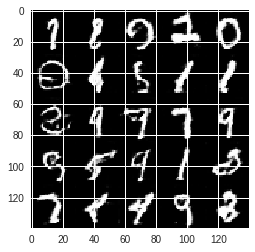

Epoch 2/2... Discriminator Loss: 1.4348... Generator Loss: 0.9030
Epoch 2/2... Discriminator Loss: 1.4572... Generator Loss: 0.7916
Epoch 2/2... Discriminator Loss: 1.7462... Generator Loss: 0.3320
Epoch 2/2... Discriminator Loss: 1.6036... Generator Loss: 0.4269
Epoch 2/2... Discriminator Loss: 1.5948... Generator Loss: 0.4335


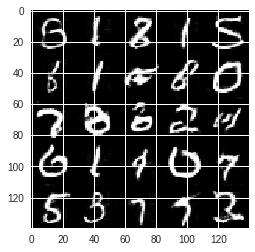

Epoch 2/2... Discriminator Loss: 1.4812... Generator Loss: 0.7261
Epoch 2/2... Discriminator Loss: 1.4438... Generator Loss: 0.6663
Epoch 2/2... Discriminator Loss: 1.6142... Generator Loss: 1.0918
Epoch 2/2... Discriminator Loss: 1.5147... Generator Loss: 0.7026
Epoch 2/2... Discriminator Loss: 1.5309... Generator Loss: 0.4549


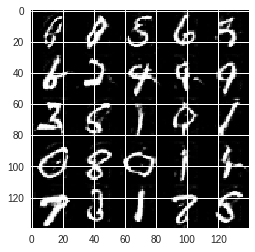

Epoch 2/2... Discriminator Loss: 1.6368... Generator Loss: 0.4255
Epoch 2/2... Discriminator Loss: 1.5599... Generator Loss: 0.5034
Epoch 2/2... Discriminator Loss: 1.5894... Generator Loss: 0.4670
Epoch 2/2... Discriminator Loss: 1.4269... Generator Loss: 0.5918
Epoch 2/2... Discriminator Loss: 1.5500... Generator Loss: 0.4853


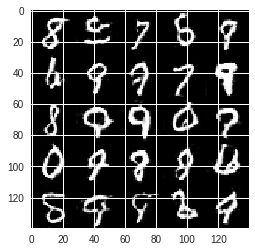

Epoch 2/2... Discriminator Loss: 1.5054... Generator Loss: 0.6750
Epoch 2/2... Discriminator Loss: 1.7315... Generator Loss: 0.9984
Epoch 2/2... Discriminator Loss: 1.6420... Generator Loss: 0.3839
Epoch 2/2... Discriminator Loss: 1.4478... Generator Loss: 0.8316
Epoch 2/2... Discriminator Loss: 1.5208... Generator Loss: 0.9925


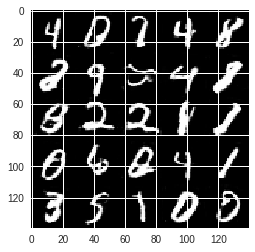

Epoch 2/2... Discriminator Loss: 1.5764... Generator Loss: 1.0268
Epoch 2/2... Discriminator Loss: 1.4976... Generator Loss: 0.8802
Epoch 2/2... Discriminator Loss: 1.5926... Generator Loss: 0.9335
Epoch 2/2... Discriminator Loss: 1.5424... Generator Loss: 0.4618
Epoch 2/2... Discriminator Loss: 1.5691... Generator Loss: 0.4918


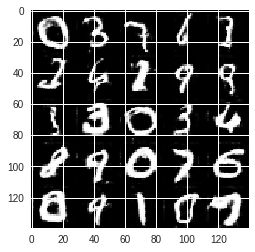

Epoch 2/2... Discriminator Loss: 1.5103... Generator Loss: 0.5192
Epoch 2/2... Discriminator Loss: 1.5946... Generator Loss: 0.4254
Epoch 2/2... Discriminator Loss: 1.6271... Generator Loss: 0.4014
Epoch 2/2... Discriminator Loss: 1.5076... Generator Loss: 0.9753
Epoch 2/2... Discriminator Loss: 1.5613... Generator Loss: 1.0243


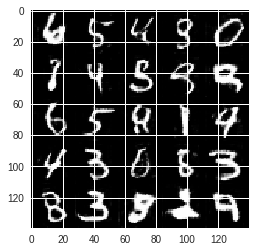

Epoch 2/2... Discriminator Loss: 1.5738... Generator Loss: 0.8629
Epoch 2/2... Discriminator Loss: 1.4688... Generator Loss: 0.9095
Epoch 2/2... Discriminator Loss: 1.5341... Generator Loss: 0.5092
Epoch 2/2... Discriminator Loss: 1.4698... Generator Loss: 0.6273
Epoch 2/2... Discriminator Loss: 1.5659... Generator Loss: 1.0635


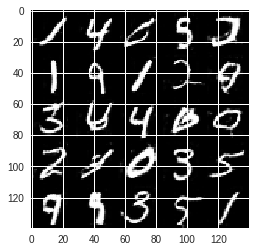

Epoch 2/2... Discriminator Loss: 1.6784... Generator Loss: 1.1985
Epoch 2/2... Discriminator Loss: 1.5501... Generator Loss: 1.0791
Epoch 2/2... Discriminator Loss: 1.5608... Generator Loss: 1.0387
Epoch 2/2... Discriminator Loss: 1.5529... Generator Loss: 1.0277
Epoch 2/2... Discriminator Loss: 1.4316... Generator Loss: 0.9000


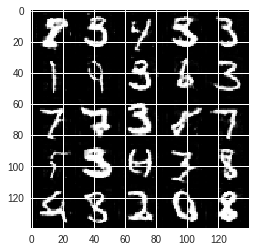

Epoch 2/2... Discriminator Loss: 1.6345... Generator Loss: 0.3884
Epoch 2/2... Discriminator Loss: 1.4501... Generator Loss: 0.8091
Epoch 2/2... Discriminator Loss: 1.4807... Generator Loss: 0.8619
Epoch 2/2... Discriminator Loss: 1.4946... Generator Loss: 0.9219
Epoch 2/2... Discriminator Loss: 1.5566... Generator Loss: 1.0882


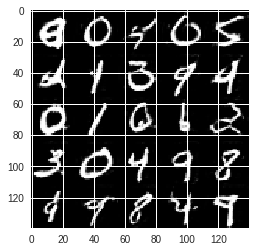

Epoch 2/2... Discriminator Loss: 1.5294... Generator Loss: 0.9217
Epoch 2/2... Discriminator Loss: 1.4989... Generator Loss: 0.5495


In [17]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 5.6016... Generator Loss: 1.0987
Epoch 1/1... Discriminator Loss: 4.3928... Generator Loss: 0.0265
Epoch 1/1... Discriminator Loss: 3.3668... Generator Loss: 0.1453
Epoch 1/1... Discriminator Loss: 2.5199... Generator Loss: 0.2839
Epoch 1/1... Discriminator Loss: 2.3189... Generator Loss: 0.2317


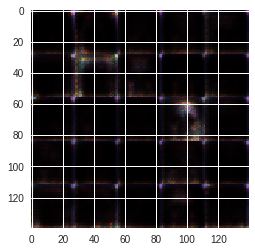

Epoch 1/1... Discriminator Loss: 2.1938... Generator Loss: 0.2553
Epoch 1/1... Discriminator Loss: 2.1610... Generator Loss: 0.2914
Epoch 1/1... Discriminator Loss: 1.9577... Generator Loss: 0.3998
Epoch 1/1... Discriminator Loss: 1.7009... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.7164... Generator Loss: 0.7274


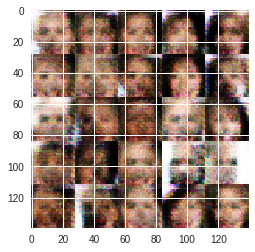

Epoch 1/1... Discriminator Loss: 1.7475... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.9649... Generator Loss: 0.3600
Epoch 1/1... Discriminator Loss: 1.7322... Generator Loss: 0.4777
Epoch 1/1... Discriminator Loss: 1.8172... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.5851... Generator Loss: 0.6604


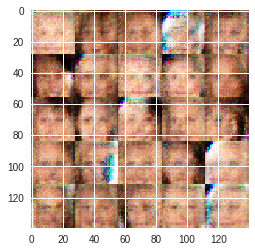

Epoch 1/1... Discriminator Loss: 1.9571... Generator Loss: 0.3473
Epoch 1/1... Discriminator Loss: 1.7465... Generator Loss: 0.4282
Epoch 1/1... Discriminator Loss: 1.8426... Generator Loss: 0.3636
Epoch 1/1... Discriminator Loss: 1.7927... Generator Loss: 0.4728
Epoch 1/1... Discriminator Loss: 1.8256... Generator Loss: 0.6629


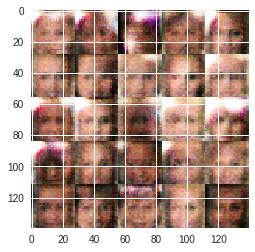

Epoch 1/1... Discriminator Loss: 1.7496... Generator Loss: 0.5948
Epoch 1/1... Discriminator Loss: 1.5407... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.5705... Generator Loss: 0.5646
Epoch 1/1... Discriminator Loss: 2.0557... Generator Loss: 0.2897
Epoch 1/1... Discriminator Loss: 1.8617... Generator Loss: 0.3847


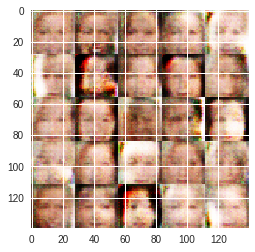

Epoch 1/1... Discriminator Loss: 1.5678... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 1.5756... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.6202... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.7221... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.6267... Generator Loss: 0.5430


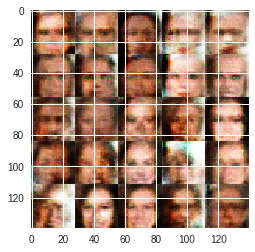

Epoch 1/1... Discriminator Loss: 1.7726... Generator Loss: 0.4417
Epoch 1/1... Discriminator Loss: 1.6378... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.5374... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.5834... Generator Loss: 0.5521
Epoch 1/1... Discriminator Loss: 1.5828... Generator Loss: 0.6205


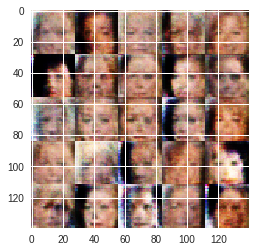

Epoch 1/1... Discriminator Loss: 1.6390... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 1.6097... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.5641... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.5874... Generator Loss: 0.5311
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.7893


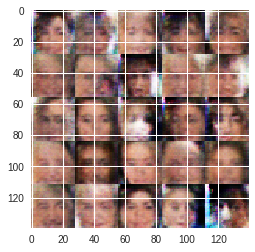

Epoch 1/1... Discriminator Loss: 1.6889... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.6465... Generator Loss: 0.5131
Epoch 1/1... Discriminator Loss: 1.6474... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 1.5820... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.6804


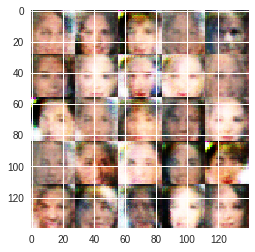

Epoch 1/1... Discriminator Loss: 1.5531... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.5894... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.6186... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.5497... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 1.8495... Generator Loss: 0.3982


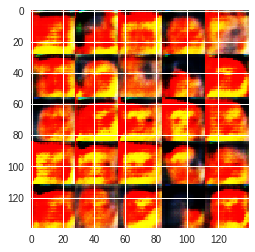

Epoch 1/1... Discriminator Loss: 1.5704... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.5352... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.5064... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.7180... Generator Loss: 0.4105
Epoch 1/1... Discriminator Loss: 1.6676... Generator Loss: 0.8457


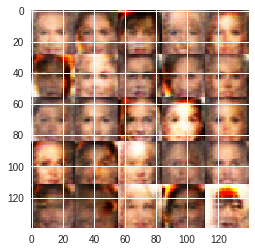

Epoch 1/1... Discriminator Loss: 1.5153... Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 1.5297... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.5351... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.7714


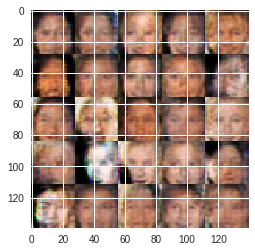

Epoch 1/1... Discriminator Loss: 1.5258... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.5416... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.5124... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.5832... Generator Loss: 1.0536


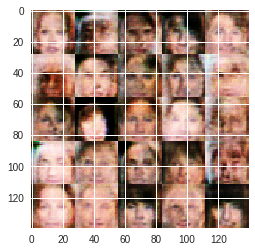

Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.6003... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 1.5338... Generator Loss: 0.6527


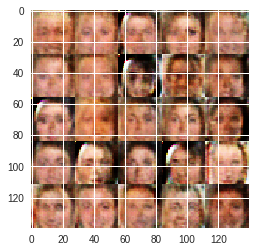

Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.5142... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.5533... Generator Loss: 0.5432
Epoch 1/1... Discriminator Loss: 1.5453... Generator Loss: 0.7257


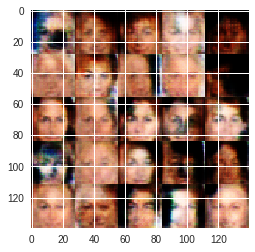

Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.5201... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.5774... Generator Loss: 0.5843
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.6199... Generator Loss: 0.5834


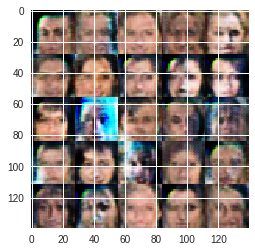

Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.5433... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.5395... Generator Loss: 0.5155
Epoch 1/1... Discriminator Loss: 1.5396... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.5592... Generator Loss: 0.9372


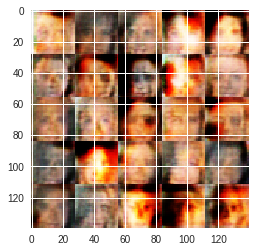

Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.6743... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.5243... Generator Loss: 0.9186
Epoch 1/1... Discriminator Loss: 1.5305... Generator Loss: 0.9629


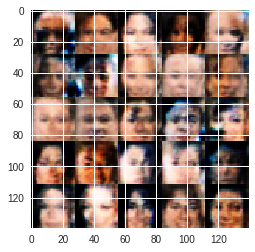

Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.9926
Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.5907
Epoch 1/1... Discriminator Loss: 1.7144... Generator Loss: 0.5055
Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.7122


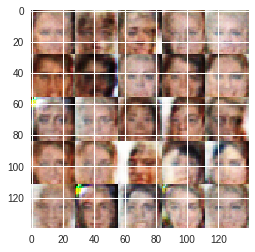

Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.9376
Epoch 1/1... Discriminator Loss: 1.5632... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.6497... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 0.6768


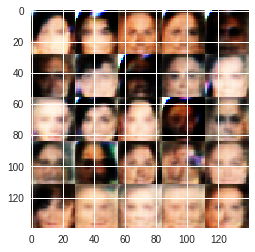

Epoch 1/1... Discriminator Loss: 1.5579... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.6052... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.6330


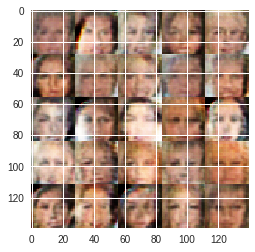

Epoch 1/1... Discriminator Loss: 1.5145... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.6190... Generator Loss: 0.4826
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.6371


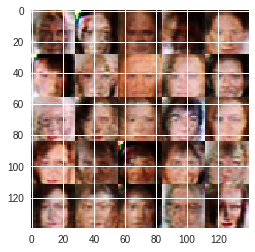

Epoch 1/1... Discriminator Loss: 1.5366... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.5128... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.6948


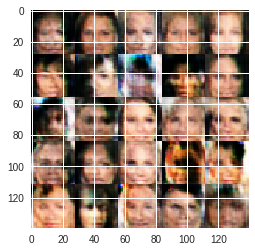

Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.5345... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.8587


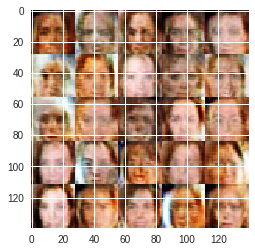

Epoch 1/1... Discriminator Loss: 1.5857... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.5268... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.5758... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.5561... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.5654... Generator Loss: 1.1014


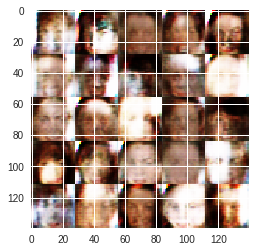

Epoch 1/1... Discriminator Loss: 1.5486... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.6097... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.5552... Generator Loss: 0.9663
Epoch 1/1... Discriminator Loss: 1.5321... Generator Loss: 0.6004
Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.7296


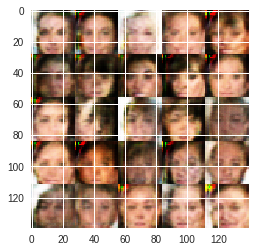

Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.5371... Generator Loss: 0.5352
Epoch 1/1... Discriminator Loss: 1.5353... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.5007... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.5287... Generator Loss: 0.7092


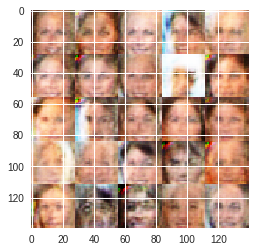

Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.5303... Generator Loss: 0.6022


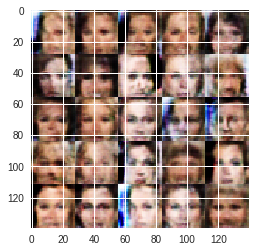

Epoch 1/1... Discriminator Loss: 1.4971... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.5616... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 1.5007... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.6342... Generator Loss: 0.5532


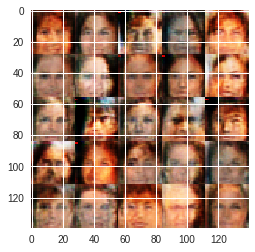

Epoch 1/1... Discriminator Loss: 1.5279... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 1.5364... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.9747


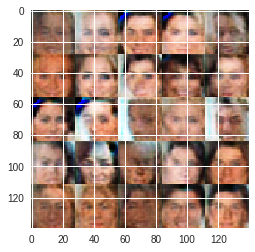

Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.5325... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.8362


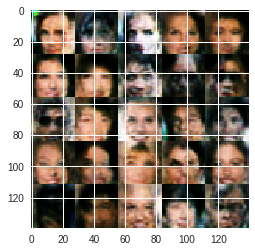

Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.5353... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.6791


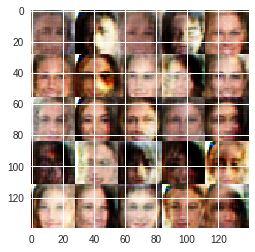

Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.5294... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.7849


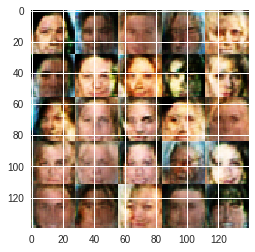

Epoch 1/1... Discriminator Loss: 1.5793... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.5459... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.7045


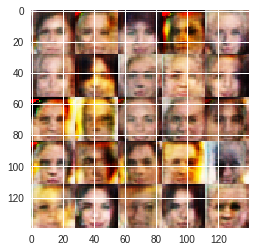

Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.5689... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.5434... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.7139


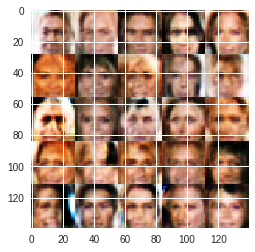

Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.5688... Generator Loss: 0.5518
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.7473


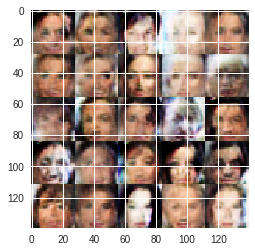

Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.5569... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.5920


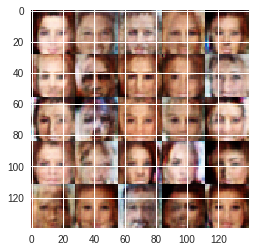

Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.8573
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.8410


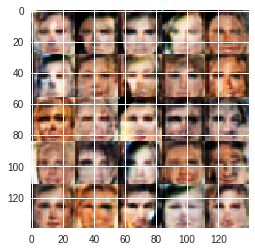

Epoch 1/1... Discriminator Loss: 1.5241... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.5201... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.5668... Generator Loss: 0.5197
Epoch 1/1... Discriminator Loss: 1.5375... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.8132


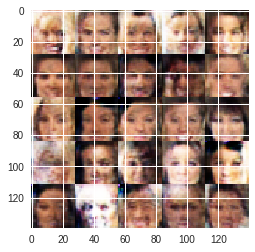

Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.4876... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 1.5001... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.7382


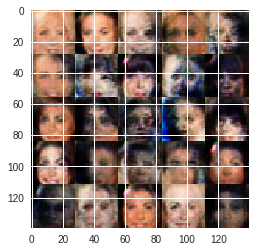

Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.6556


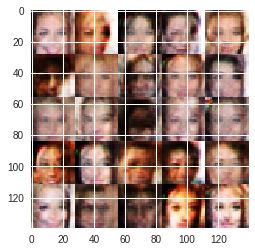

Epoch 1/1... Discriminator Loss: 1.5191... Generator Loss: 0.5721
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.7274


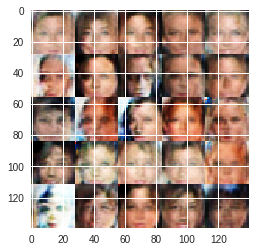

Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.5807
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 1.0278
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.6215


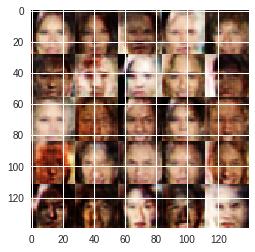

Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.6134... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.5142... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.4965... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.5436... Generator Loss: 0.6658


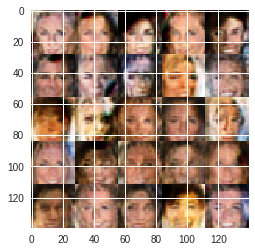

Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.5027... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.7966


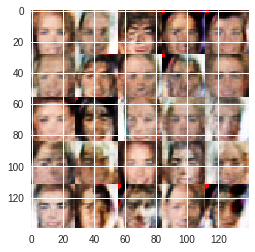

Epoch 1/1... Discriminator Loss: 1.5448... Generator Loss: 0.4933
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.5305... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.6635


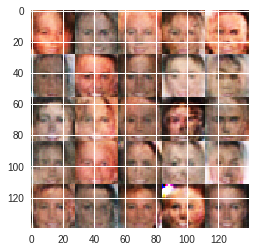

Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.5215... Generator Loss: 0.5256


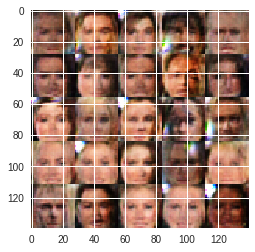

Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.8707


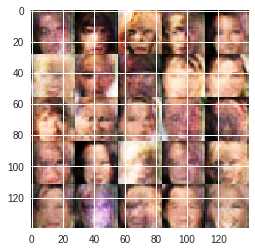

Epoch 1/1... Discriminator Loss: 1.5278... Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 1.5407... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.6396


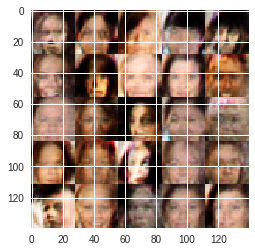

Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.5094... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.7925


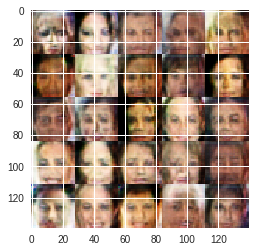

Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.6641


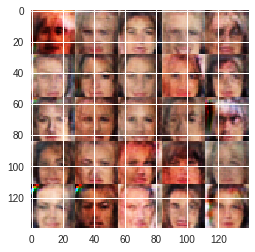

Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.5051... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.6179


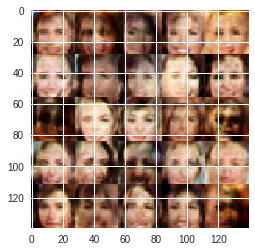

Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.5878


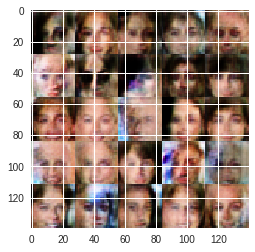

Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.5358... Generator Loss: 0.5556


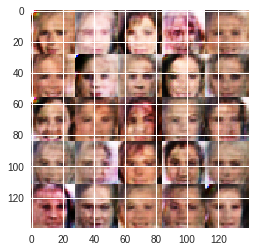

Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.5843
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.5014... Generator Loss: 0.5843
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.7537


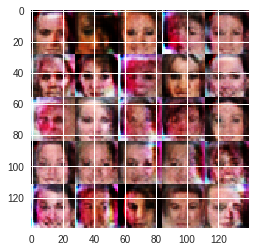

Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.8237


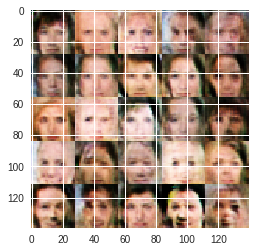

Epoch 1/1... Discriminator Loss: 1.4956... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.6084


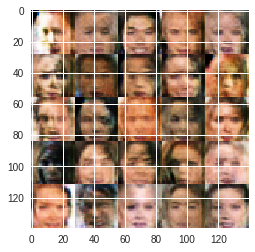

Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.5024... Generator Loss: 1.1142
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.5252


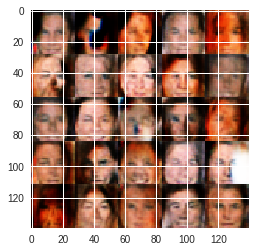

Epoch 1/1... Discriminator Loss: 1.5007... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 0.9047
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.7880


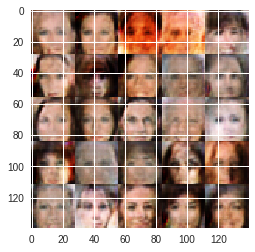

Epoch 1/1... Discriminator Loss: 1.5173... Generator Loss: 0.5564
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.5373


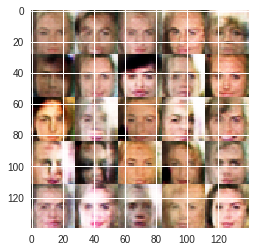

Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.7561


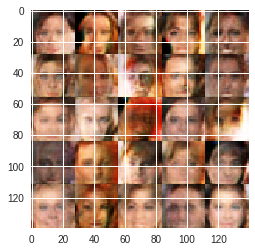

Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.5156... Generator Loss: 1.0755
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.7639


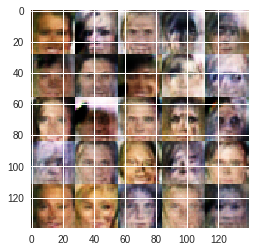

Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.6112


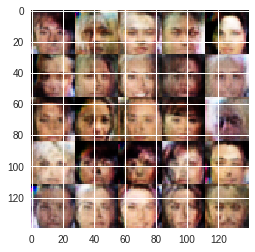

Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.6802


In [18]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.